# Diffusion models

In this notebook you will learn ho to train a diffusion model to sample images from random noise.
Diffusion Models are generative models which have been gaining significant popularity in the past several years. They are currently used by DALL-E 2, 0penAI’s image generation and other platforms.

The goal of diffusion models is to learn a diffusion process that generates a probability distribution for a given dataset from which we can then sample new images.

In the case of computer vision, diffusion models can be applied to a variety of tasks, including image denoising, inpainting, super-resolution, and image generation. This typically involves training a neural network to sequentially denoise images blurred with Gaussian noise.

In [1]:
# install missing packages
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.2 MB/s eta 0:00:00


In [2]:
# import libraries

# dee learning base lib
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid

# dataset
from datasets import load_dataset

# diffusion models
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid

# visualization
import matplotlib.pyplot as plt
from PIL import Image

2024-07-19 22:29:57.979795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 22:29:57.979955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 22:29:58.125685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# dataset containing images of many flowers, consider only a small fraction
dataset = load_dataset("huggan/flowers-102-categories", split='train[:10%]')

Generating train split:   0%|          | 0/8189 [00:00<?, ? examples/s]

In [4]:
# load the butterflies dataset from hugging face
# dataset = load_dataset("huggan/smithsonian_butterflies_subset", split='train')

In [5]:
# data augumentation 
image_size=64
preprocess=transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize
        # transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ])

In [6]:
# pre-process dataset
dataset.set_transform(preprocess)
batch_size=64
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

device="cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# let's print some images
print(f"Batch size: {batch_size}")
print(f"Dataset size (nb batches): {len(train_dataloader)}")
print(f"Device found: {device}")

Batch size: 64
Dataset size (nb batches): 13
Device found: cuda


In [8]:
# Utility function used to display images
def show_images(image):
    plt.imshow(make_grid(image*0.5+0.5).permute(1,2,0))

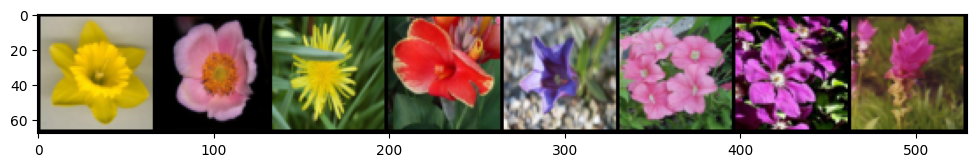

In [9]:
# plot one example
batch=next(iter(train_dataloader))
plt.figure(figsize=(12,5))
show_images(batch['images'][:8])

In [10]:
# we will use a random noise generator for each timestamp
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02)
# we will use a version of a UnetModel that is particularly used for image diffusion since it outputs an image of the same size of its input 
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [11]:
# TRAINING
num_epochs=50 # nb of epochs
ls=1e-4 # learning rate
model=model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=ls) # optimizer
losses = []

# training steps
# for each step of an epoch
# - generate random noise
# - add random noise to alterate the input sample
# - predict noise from the altered images
# - calculate the loss between the predicted noise and the random generated one
# - gradient descent
# - repeat for other samples
for epoch in range(num_epochs+1):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)

        noise = torch.randn(clean_images.shape).to(clean_images.device)
        timesteps = torch.randint(
            0,
            scheduler.num_train_timesteps,
            (clean_images.shape[0],),
            device=clean_images.device,
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} Loss {loss}")
    if (epoch)%5==0:
        PATH = f'model_{epoch}.pth'
        torch.save(model.state_dict(), PATH)

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 Loss 0.13955166935920715
Epoch 1 Loss 0.1027219220995903
Epoch 2 Loss 0.09334319829940796
Epoch 3 Loss 0.06592889875173569
Epoch 4 Loss 0.11815102398395538
Epoch 5 Loss 0.07132014632225037
Epoch 6 Loss 0.07214612513780594
Epoch 7 Loss 0.08175301551818848
Epoch 8 Loss 0.07131977379322052
Epoch 9 Loss 0.06427329033613205
Epoch 10 Loss 0.06746885925531387
Epoch 11 Loss 0.04937875270843506
Epoch 12 Loss 0.07101656496524811
Epoch 13 Loss 0.05814918130636215
Epoch 14 Loss 0.0704716369509697
Epoch 15 Loss 0.0635518878698349
Epoch 16 Loss 0.03898466005921364
Epoch 17 Loss 0.062051404267549515
Epoch 18 Loss 0.05329026281833649
Epoch 19 Loss 0.05222060903906822
Epoch 20 Loss 0.07791918516159058
Epoch 21 Loss 0.05274913087487221
Epoch 22 Loss 0.04603293165564537
Epoch 23 Loss 0.045980121940374374
Epoch 24 Loss 0.05178571864962578
Epoch 25 Loss 0.043079257011413574
Epoch 26 Loss 0.03789530321955681
Epoch 27 Loss 0.04427260905504227
Epoch 28 Loss 0.051200833171606064
Epoch 29 Loss 0.0421738

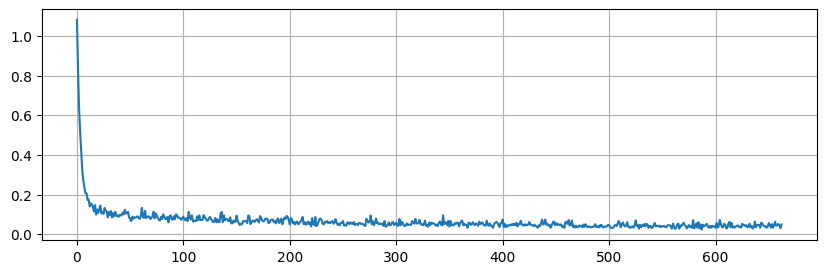

In [12]:
# print losses per step
plt.figure(figsize=(10,3))
plt.plot(losses)
plt.grid()

In [13]:
# function to sample some images from random noise (backward diffusion)
def eval_model(epoch_model, inference_steps=1000):
    nn_model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    )
    # select the model that corresponds to a specific epoch
    nn_model.load_state_dict(torch.load(f"model_{epoch_model}.pth", map_location=device))
    nn_model.eval()
    print("Loaded in Model")
    
    # Once we have trained our model let's generate some random images.
    # We can do that by using DDPMPipeline to run inference of diffusion models
    pipe = DDPMPipeline(unet=nn_model, scheduler=scheduler)
    pipe.to(device)
    generated_image = pipe(batch_size=16, num_inference_steps=inference_steps, output_type='pil', return_dict=True)
    # batch_size: how many images to sample during evaluation
    images = generated_image[0][:16]
    
    
    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)
    
    # Lets plot the new generated images
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image_grid)
    ax.axis('off')
    ax.set_title('New generated images', fontsize=16)
    plt.show()

Loaded in Model


  0%|          | 0/500 [00:00<?, ?it/s]

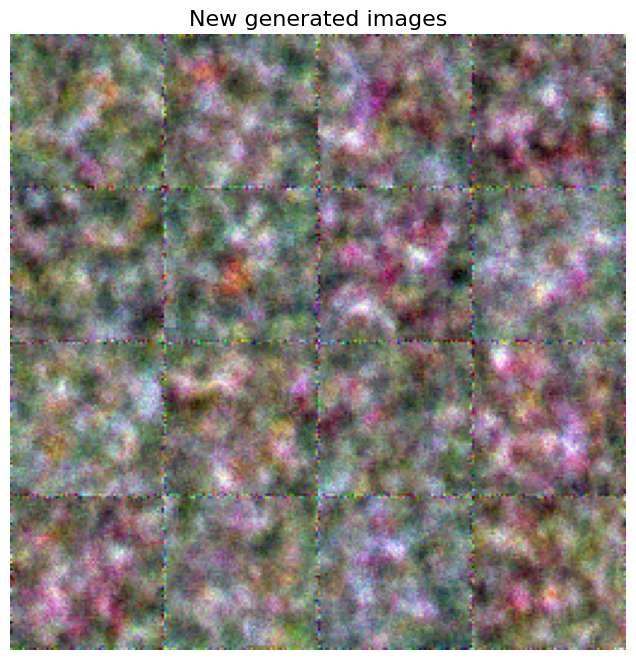

In [14]:
# epoch 5
# inference stesp 500
eval_model(5, 500)

Loaded in Model


  0%|          | 0/1000 [00:00<?, ?it/s]

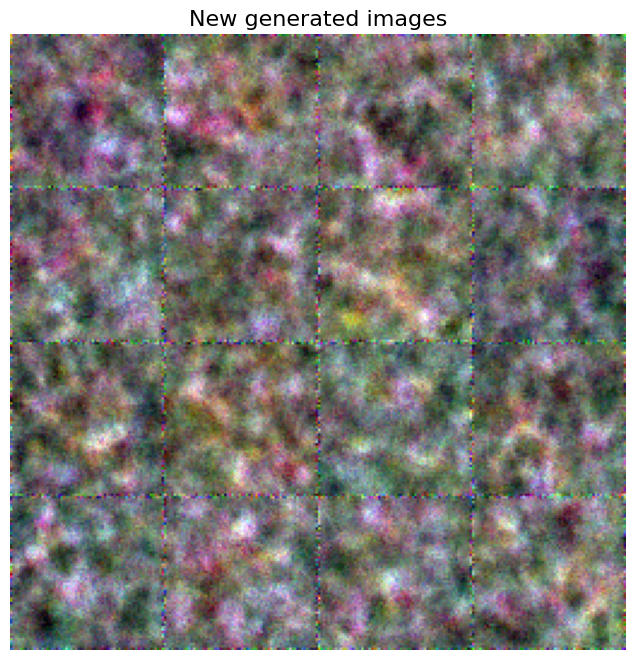

In [15]:
# epoch 5
# inference steps 1000
# we can observe that by increasing the inference steps the noise decreases
eval_model(5, 1000)

Loaded in Model


  0%|          | 0/1000 [00:00<?, ?it/s]

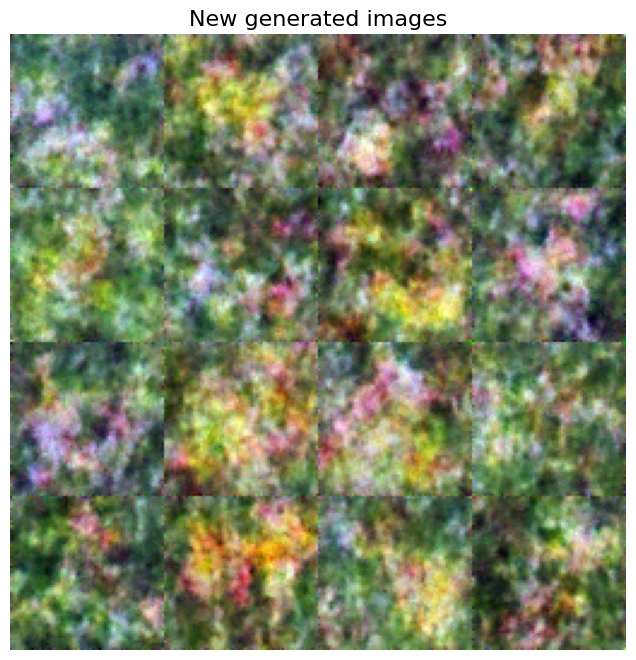

In [16]:
# epoch 30
# inference steps 1000
eval_model(30, 1000)

Loaded in Model


  0%|          | 0/1000 [00:00<?, ?it/s]

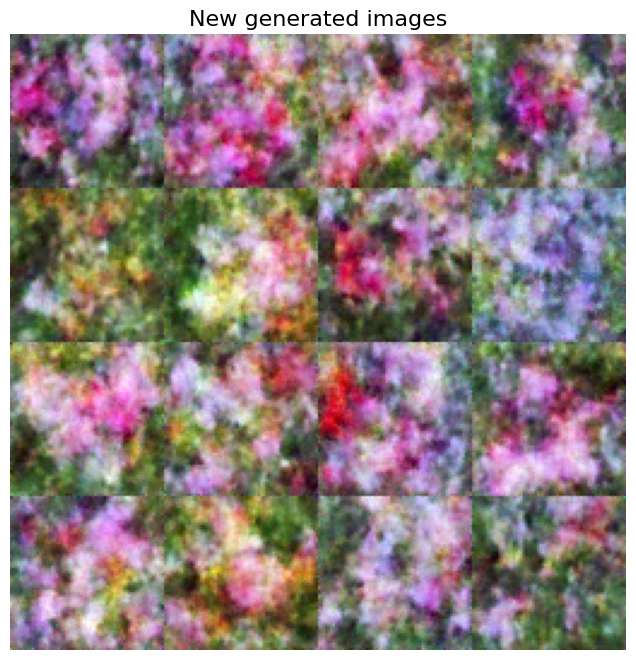

In [17]:
# epoch 50
# inference steps 1000
# model trained longer should have better results
eval_model(50, 1000)

# Use a pretrained model

In [18]:
# We will now see how to use text prompt on a pre-trained model to generate an image

from diffusers import StableDiffusionPipeline

# Load a pre-trained Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
# Define a text prompt describing the desired image
prompt = "Cat driving a car"

# Generate an image from the prompt
generated_image = pipe(prompt=prompt, height=768, width=512).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

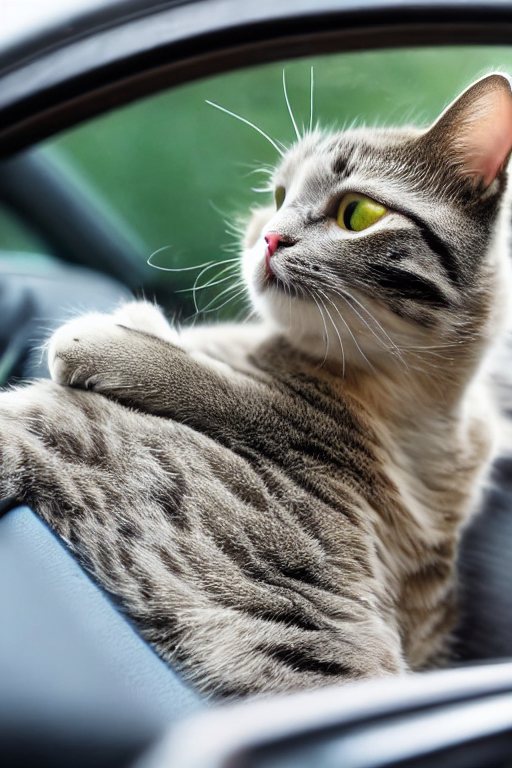

In [20]:
generated_image

In [21]:
# Save the generated image
generated_image.save("ddpm_generated_image.png")